<a href="https://colab.research.google.com/github/pabloac31/TFG/blob/master/cifar10_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Clone the repository**

In [0]:
! git clone https://github.com/pabloac31/TFG.git
%cd TFG

Cloning into 'TFG'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 243 (delta 35), reused 14 (delta 7), pack-reused 183
Receiving objects: 100% (243/243), 217.32 MiB | 38.11 MiB/s, done.
Resolving deltas: 100% (128/128), done.
Checking out files: 100% (30/30), done.
/content/TFG


**Using Tensorflow v1**

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


**Import libraries**

In [0]:
from cifar10_models import *
from utils import *
from adversarial_attacks import *

**Use CUDA if available**

In [0]:
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


**Create dataloaders**

Load CIFAR10 test images as tensors of size NxCxHxW normalized with CIFAR10 mean and std.

In [0]:
test_loader = testloader_cifar10('./data', batch_size=256, shuffle=False)   # Used to test the models
adv_loader = testloader_cifar10('./data', batch_size=1)                     # Used for adversarial attacks
univ_loader = testloader_cifar10('./data', batch_size=1000, shuffle=False)  # Used for the X-set in the universal attack
full_loader = testloader_cifar10('./data', batch_size=10000, shuffle=False) # Used to calculate the overall fooling rate in the universal attack

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


**Load models pretrained on CIFAR10**

In [0]:
resnet = resnet50(pretrained=True)
densenet = densenet169(pretrained=True)
mobnet = mobilenet_v2(pretrained=True)
iv3 = inception_v3(pretrained=True)

**Test models**

In [0]:
acc = test_model(resnet, device, test_loader)
print('\nAccuracy on the CIFAR10 test set:', acc)

100%|██████████| 40/40 [00:05<00:00,  7.40it/s]


Accuracy on CIFAR10 test set:  0.9212


**Set method parameters**

In [0]:
params_fgsm = {'epsilon': 0.01, 'clip': True}
params_deepfool = {'num_classes': 10, 'overshoot': 0.01, 'max_iter': 50, 'p': 2, 'clip': True}
params_sparsefool = {'delta': 255, 'lambda_': 3.0, 'max_iter': 50, 'epsilon': 0.02}
params_opa = {'dim': 1, 'target_label': None, 'iters': 100, 'pop_size': 400, 'verbose': True}

**Testing a method on a random CIFAR10 image**

In [0]:
image, label = next(iter(adv_loader))
test_method(resnet, device, image, label, method='deepfool', params=params_deepfool)

**Perform a complete attack and show the results**

In [0]:
adv_examples = attack_model(resnet, device, adv_loader, 'deepfool', params_deepfool)

**Preparing datasets for the universal method**

In [0]:
# Images on the set X used to compute the universal perturbation
dataset, labels = next(iter(univ_loader))
print(dataset.size())

# Images on the CIFAR10 test set, used to calculate the overall fooling rate
testset, labels_test = next(iter(full_loader))
print(testset.size())

torch.Size([1000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])


**Obtaining an universal perturbation**

In [0]:
v, fooling_rate = universal_perturbation(dataset, labels, resnet, device, delta=0.2, xi=3*5, max_iter_uni=10, p=2)
print('Fooling rate on X:', fooling_rate)

  0%|          | 0/1000 [00:00<?, ?it/s]

Starting pass number  0


  0%|          | 0/1000 [00:00<?, ?it/s]

FOOLING RATE =  0.695
Starting pass number  1


  0%|          | 0/1000 [00:00<?, ?it/s]

FOOLING RATE =  0.727
Starting pass number  2


100%|██████████| 10/10 [00:00<00:00, 12.21it/s]

FOOLING RATE =  0.8
Total time: 306.78
Total iters: 3
Norm of the univ. perturbation: 14.999999046325684
Fooling rate on X: 0.8


**Calculate the overall fooling rate**

In [0]:
univ_fool_rate(resnet, device, testset, v, batch_size=250)

100%|██████████| 100/100 [00:08<00:00, 12.14it/s]


0.7606

**Save/load an universal perturbation**

In [0]:
torch.save(v, 'resnet_15.pt') 
#v = torch.load('resnet_15.pt')

**Show some adversarial examples obtained from the universal perturbation v**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


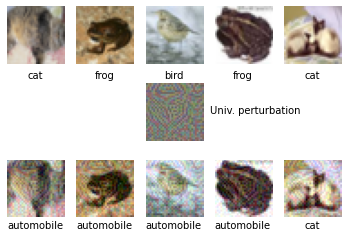

In [0]:
show_univ_examples(5, resnet, device, v)

**Show the universal perturbation**

tensor(25.5024, device='cuda:0')


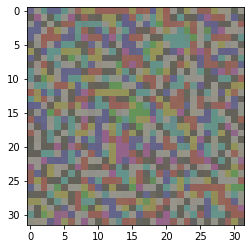

In [0]:
plt.axis('off')
plt.imshow(displayable(v.cpu()))